# Feature scaling

An important part of any data analysis task is preparing your data. Depending on the tak you are trying to do, and the algorithms you are using, the data preparation steps will vary. In this section we will learn about feature scaling and dimensionality reduction.

Let's look at [some data representing wine](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset). The data contains information on 178 samples of wine, measuring a number of things, including the alcoholic content, the amount of magnesium, the amount of proline and many more. Each sample also has a class associated with it, representing the variety of the grape used.

In [1]:
from sklearn.datasets import load_wine

X, y = load_wine(as_frame=True, return_X_y=True)
y = y.astype("category")  # This makes seaborn use the right colour palette
X

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     od280/od315_of_diluted_wines  proline  
0                            3.92   1065.0  
1                            3.40   1050.0  
2                            3.17   1185.0  
3                            3.45   1480.0  
4                            2.93    735.0  
..                            ...      ...  
173                          1.74    740.0  
174                          1.56    750.0  
175                          1.56    835.0  
176                          1.62    840.0  
177                          1.60    560.0  

[178 rows x 13 columns]

To keep things easier to visualise, we'll just grab two of the features:

In [2]:
X_subset = X[["alcohol", "proline"]]

First, let's have a look at the data and see how it's distributed:

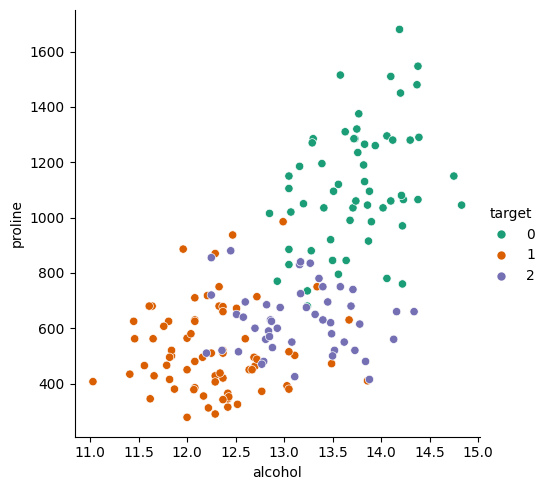

In [3]:
import seaborn as sns
import pandas as pd

sns.relplot(data=X, x="alcohol", y="proline", hue=y, palette="Dark2")

The classes look relatively distinct from each other so a k-nearest neighbours should do the trick. First we split our data in test and train (the `_s` suffix represents our 2-feature subset):

In [4]:
from sklearn.model_selection import train_test_split

train_X_s, test_X_s, train_y_s, test_y_s = train_test_split(X_subset, y, random_state=42)

Then we fit and score our model, without any further tweaking or tuning:

In [5]:
from sklearn.neighbors import KNeighborsClassifier

direct_knn = KNeighborsClassifier()
direct_knn.fit(train_X_s, train_y_s)
direct_knn.score(test_X_s, test_y_s)

0.6666666666666666

That looks like it's worked, but I would expect a higher score for such a simple data set. Getting a third of the data wrong seems high.

Let's use our visualisation function again to see of there's anything obviously wrong:

<Axes: xlabel='alcohol', ylabel='proline'>

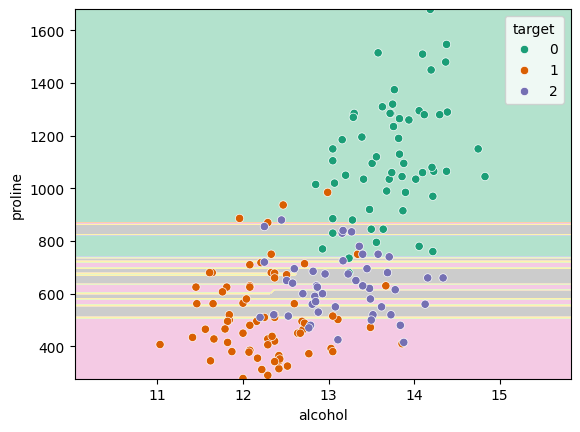

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(direct_knn, X_subset, cmap="Pastel2")
sns.scatterplot(data=X_subset, x="alcohol", y="proline", hue=y, palette="Dark2")

We can immediately see here that there's some issue. The kNN algorithm should be creating nice smooth and round regions in the data but they seem here to be be very horizontally striped.

One potential reason for this could be that the number of neighbours is incorrect, so you could run a grid search to check the best value for the hyperparameter. In this case however, there's a more fundamenetal issue with the data.

If you look at the absolute values on the $x_1$ and $x_2$ axes you'll see that the ranges over which they vary are vastly different. The `alcohol` data goes from 11 to 15, but the `proline` data goes from 300 to 1700. This causes a problem with algorithms like kNN as the metric that they use to classify is based on euclidean distance. That means that it assumes that a distance of $\Delta x_1$ has the same importance as a distance $\Delta x_2$. If we plot our data the way that kNN sees it, it looks like:

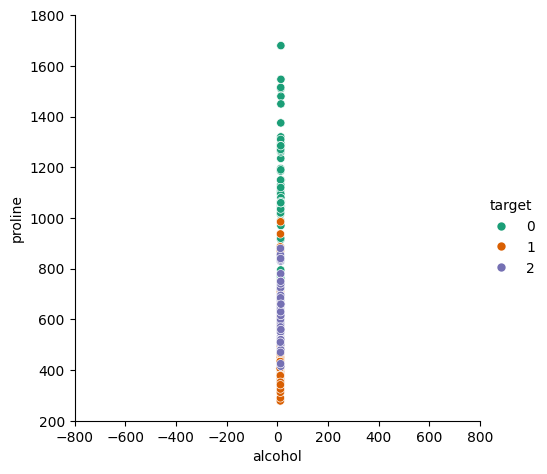

In [7]:
sns.relplot(data=X, x="alcohol", y="proline", hue=y, palette="Dark2").set(aspect="equal", xlim=(-800, 800), ylim=(200, 1800))

There's such a vast difference in the scales that they look like they're all in a straight line! It's clear that the values in the two directions are not equally weighted, so we need to do something about it.

The standard way is to take the values in each feature, $x$ and calculate their mean, $\mu$, and standard deviation, $\sigma$ and scale the values such that $x^{\prime} = \frac{x - \mu}{\sigma}$.

scikit-learn provides a scaler called [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which can do this for you. It works like any other scikit-learn model and so has a [`fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit) method:

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

At this point, the scaler has calculated the $\mu$ and $\sigma$ for each feature (you can check with `scaler.mean_` and `scaler.var_`). We can ask it to actually perform the scaling by calling the [`transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform) method. This returns a numpy array, so if we want to keep it as as a pandas `Dataframe`, we need to explicitly convert it back:

In [9]:
X_scaled_raw = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_raw, columns=X.columns)

Plotting the result shows a nice balanced spread of data (note the new scales on the axes):

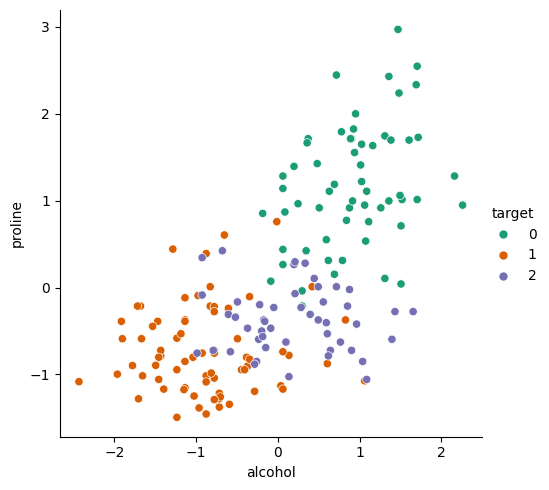

In [10]:
sns.relplot(data=X_scaled, x="alcohol", y="proline", hue=y, palette="Dark2")

## Pipelines

To incorporate this scaling process into our model, we need to make sure that:
1. the scaling factors are calculated once and are not changed from that point on,
2. the scaling is applied to the training data,
3. the scaling is applied to the test data,
4. the scaling is applied to any data used in a prediction.

The easiest way to ensure this is to use [a pipeline](https://scikit-learn.org/stable/modules/compose.html). This lets us assemble multiple steps together and scikit-learn knows how to pass data between them.

In [11]:
from sklearn.pipeline import make_pipeline

scaled_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)
scaled_knn

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

A pipeline acts like any other scikit-learn model so we can still use our `fit`, `score` and `predict` methods. Any data we pass in will be passed through all the steps in the correct way:

In [12]:
scaled_knn.fit(train_X_s, train_y_s)
scaled_knn.score(test_X_s, test_y_s)

0.8666666666666667

Our training data has been used to calculate the scaling parameters, has been transformed and then used to fit the kNN model. The test data was then passed through to be scaled and scored using the kNN model.

We can plot our decision boundary again and now it's looking much more reasonable:

<Axes: xlabel='alcohol', ylabel='proline'>

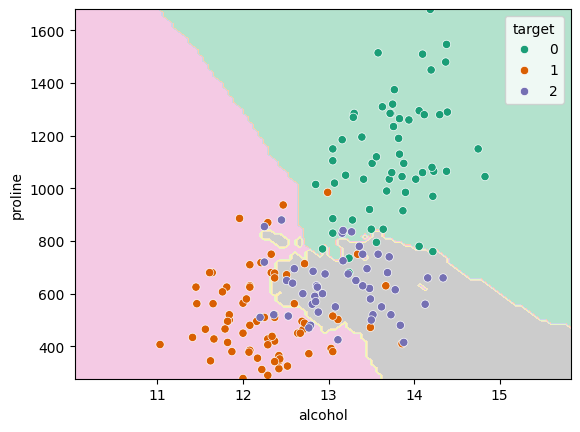

In [13]:
DecisionBoundaryDisplay.from_estimator(scaled_knn, X_subset, cmap="Pastel2")
sns.scatterplot(data=X_subset, x="alcohol", y="proline", hue=y, palette="Dark2")

## Principal component analysis

In our data so far, we have used just two of the feature columns in our data. We primarily did this to make plotting the data easier to understand. There's nothing stopping us from passing *all* our features to our pipeline:

In [14]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)  # re-split using all columns

In [15]:
scaled_knn_all = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)
scaled_knn_all

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [16]:
scaled_knn_all.fit(train_X, train_y)
scaled_knn_all.score(test_X, test_y)

0.9555555555555556

So, adding more features does seem to have improved our score. However, many algorithms (including kNN) are disproportionaly negatively affected by an increase in the number of features. This is due to something called [the curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). Our data points become much further apart in n-dimensional space and so the definition of a neighbourhood becomes harder to measure.

The solution to this is [dimensionality reduction](https://scikit-learn.org/stable/modules/decomposition.html) which aims to identify either the most important features, or to find useful combinations of features, which still retain enough of the information in the system.

The most common of these is [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) which makes linear combinations of the features into new features. For example, instead of selecting two features (`alcohol` and `proline`) to input into the model, we can use PCA to calculate the two most important principal components by combining all the available features.

This step can be included in our pipeline, just after the `StandardScaler`:

In [17]:
from sklearn.decomposition import PCA

scaled_pca_knn = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),  # PCA with 2 components
    KNeighborsClassifier()
)
scaled_pca_knn

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [18]:
scaled_pca_knn.fit(train_X, train_y)
scaled_pca_knn.score(test_X, test_y)

0.9777777777777777

That seems to have helped the model.

If we want to plot our decision boundary, we need to do a little more work to pull out the transformation steps from the final kNN step. You can access the steps in a pipeline like a Python list:

In [19]:
transformer_steps = scaled_pca_knn[:-1]  # all except the last step
knn_step = scaled_pca_knn[-1]  # only the last step

so then we can transform the data and pass it, along with the kNN step, into our plotting function:

<Axes: xlabel='0', ylabel='1'>

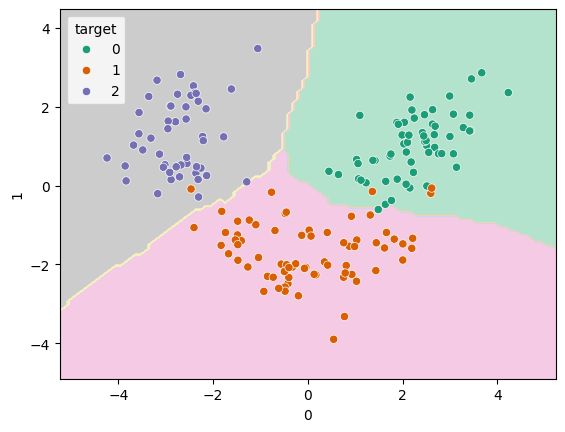

In [20]:
transformed_X = pd.DataFrame(transformer_steps.transform(X))

DecisionBoundaryDisplay.from_estimator(knn_step, transformed_X, cmap="Pastel2")
sns.scatterplot(data=transformed_X, x=0, y=1, hue=y, palette="Dark2")

That data is looking nicely separated by class and the decision boundaries are smooth.

### Number of principal components

In the example above, I chose `n_components=2` so that we'd be able to plot the decision boundary easily. There is however, no reason to limit ourselves to this. Every additional principal component we include increases the amount of information that's included. We can see how much of the variance in the data is explained by each component:

In [21]:
scaled_pca_knn["pca"].explained_variance_ratio_

array([0.3639525 , 0.18617733])

So the first provides 36% and the second 19%. It's more useful to look at the sum of the included components (as you include more components, the number will get closer to 100%):

In [22]:
sum(scaled_pca_knn["pca"].explained_variance_ratio_)

0.5501298349276385

So only about half the variance was explained by the first two components, but it's sufficient to have got a very good score previously.

We can use the `GridSearchCV` tool to try different values and see which works best:

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

scaled_pca_knn_cv = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        KNeighborsClassifier()
    ),
    {
        "pca__n_components" : range(1, 5),
    }
)
scaled_pca_knn_cv

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'pca__n_components': range(1, 5)})

In [24]:
scaled_pca_knn_cv.fit(train_X, train_y)
scaled_pca_knn_cv.score(test_X, test_y)

0.9777777777777777

In [25]:
scaled_pca_knn_cv.best_estimator_["pca"].n_components_

3

### Exercise

Take the [Iris data set from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) and make a classifier which can predict the species. Try building up your solution in the following steps:
1. First use a kNN by itself
2. Add in a feature-scaling step
3. Add in a PCA step

You can load the data with
```python
from sklearn.datasets import load_iris

X, y = load_iris(as_frame=True, return_X_y=True)
```